In [24]:
# -*- coding:utf-8 -*-
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import time
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import datetime

In [2]:
#중간 저장 주기, 파일 경로
save_when = 50
save_path = 'c:/cr/'
font_path_window="c:/Windows/Fonts/malgun.ttf"
driver_path = 'c:/cd/chromedriver'

In [3]:
browser = webdriver.Chrome(driver_path)
browser.implicitly_wait(3)

In [4]:
def searching_insta(browser):
    url = 'https://www.instagram.com/explore/tags/{}'.format(word)
    browser.get(url)

In [5]:
def click_1st(browser):
    browser.find_element_by_css_selector('a > div > div._si7dy').click()

In [6]:
def get_current_url(browser):
    article_url = browser.current_url
    return article_url

In [7]:
def get_author(browser):
    author = browser.find_element_by_css_selector('li._ezgzd > a').text
    return author

In [8]:
def get_content(browser):
    content = browser.find_element_by_css_selector('li._ezgzd > span').text
    return content

In [9]:
def get_reply(browser):
    more_reply = True
    while more_reply:
        try:
            browser.find_element_by_css_selector('a._m3m1c._1s3cd').click()
            time.sleep(1)
        except:
            more_reply = False
            break
    
    replies = browser.find_elements_by_css_selector('li._ezgzd')[1:]
    reply_result = []
    for reply in replies:
        reply_author = reply.find_element_by_css_selector('a').text
        reply_content = reply.find_element_by_css_selector('span').text
        reply_result.append([reply_author, reply_content])
    return reply_result

In [10]:
def get_content_type(browser):
    try:
        video_check = browser.find_element_by_css_selector('section._1w76c._nlmjy > div > span')
        if video_check.text[:2] == '조회':
            content_type = '동영상'
            
        else:
            content_type = '이미지'
    
    except:
        content_type = '이미지'
        
    return content_type

In [11]:
def get_img_likes(browser):
    plays = 1
    
    try:      
        check = browser.find_element_by_css_selector('section._1w76c._nlmjy > div').text
                
        if check[-3:] == '합니다':
            likes = len(browser.find_elements_by_css_selector('section._1w76c._nlmjy > div > a'))
                        
        else:
            likes = int(check[4:-1].replace(',',''))
                                
        return likes, plays
                                                           
    except:
        likes = 0
        return likes, plays

In [12]:
def get_vid_likes(browser):
    check = browser.find_element_by_css_selector('section._1w76c._nlmjy > div > span > span')

    plays = check.text
           
    check.click()
        
    likes = browser.find_element_by_css_selector('section._1w76c._nlmjy > div > div > div._m10kk > span').text
        
    browser.find_element_by_css_selector('section._1w76c._nlmjy > div > div > div._7px37').click()
    
    plays = int(plays.replace(',',''))
    likes = int(likes.replace(',',''))
    
    return likes, plays

In [13]:
def get_likesandplays(browser):
    content_type = get_content_type(browser)
    if content_type == '이미지':
        likesandplays = get_img_likes(browser)
    
    elif content_type == '동영상':
        likesandplays = get_vid_likes(browser)
    
    return likesandplays

In [14]:
def get_tags(browser):
    content = get_content(browser)
    tags = re.findall(r'#[^\s#,\\]+', content)
    return tags

In [15]:
def get_location(browser):
    try:
        location = browser.find_element_by_css_selector('div._j56ec > div._60iqg > a').text
    
    except NoSuchElementException:
        location = 'none'
    
    return location

In [16]:
def tag_result():
    f = open(txt_path, 'r', encoding = 'utf8')
    tags = f.read()
    f.close()
    
    tags = tags.split('\n')
    tag_count = Counter(tags)
    print(tag_count)

    %matplotlib inline
    
    wordcloud = WordCloud(font_path= font_path_window, background_color="white", 
                          max_words=100).generate_from_frequencies(tag_count) #font_step=5
    plt.figure(figsize=(20,15))
    plt.imshow(wordcloud)
    plt.axis('off')

In [36]:
def move_next(browser):
    browser.find_element_by_css_selector('div._23gmb > div > div > a._3a693.coreSpriteRightPaginationArrow').click()

In [18]:
#태그 트렌드: 게시물의 태그만 수집하여 태그 순위 리포트 - 클라우드 출력, 파일로 저장.
def find_tagtrend(browser):
    tags = []    
    
    for i in range(num):                
        tags += get_tags(browser)

        index = int(i+1)
        print('{}번째 크롤링 중'.format(index))

        if index % save_when == 0:
            f = open(txt_path, 'a+', encoding = 'utf8')
            f.write('\n'.join(tags))
            f.close()
            print('- 중간 결과를 저장했습니다 -')
            tags = []
        
        try:
            move_next(browser)
            time.sleep(2)
            
        except NoSuchElementException:
            f = open(txt_path, 'a+', encoding = 'utf8')
            f.write('\n'.join(tags))
            f.close()
            
            
    f = open(txt_path, 'a+', encoding = 'utf8')
    f.write('\n'.join(tags))
    f.close()

    print('''
    - 최종 결과를 저장했습니다 - 
    - 모든 크롤링을 마쳤습니다 - 
    ''')
    
    tag_result()

In [19]:
#인기 게시물: 게시물의 좋아요를 수집하여 Top10 게시물의  좋아요 숫자, 게시글 저자, 본문, 게시글 링크 리포트 - 데이터프레임 출력, 파일로 저장.
def find_top10(browser):
    best_likes = [[0, 0, '', '', ''], [0, 0, '', '', ''], [0, 0, '', '', ''], [0, 0, '', '', ''], [0, 0, '', '', ''], [0, 0, '', '', ''], [0, 0, '', '', ''], [0, 0, '', '', ''], [0, 0, '', '', ''], [0, 0, '', '', '']]
    
    for i in range(num):                     
        index = int(i+1)

        print('{}번째 크롤링 중'.format(index))
        
        likes = get_likesandplays(browser)[0]
        plays = get_likesandplays(browser)[1]
        author = get_author(browser)
        article = get_content(browser)
        article_url = get_current_url(browser)
        
        result = [likes, plays, author, article, article_url]
        
        if result > best_likes[9]:
            best_likes.append(result)       
            
            best_likes.sort()
            best_likes.reverse()
            drop = best_likes.pop()
            
        if index % save_when == 0:
            rankings = pd.DataFrame(best_likes, columns=['좋아요', '재생수', '작성자', '본문', 'url'])
            rankings.to_csv(csv_path)
            print('- 중간 결과를 저장했습니다 -')
        
        try:
            move_next(browser)
            time.sleep(2)
            
        except NoSuchElementException:
            rankings = pd.DataFrame(best_likes, columns=['좋아요', '재생수', '작성자', '본문', 'url'])
            rankings.to_csv(csv_path)
                    
    rankings = pd.DataFrame(best_likes, columns=['좋아요', '재생수', '작성자', '본문', 'url'])
    rankings.to_csv(csv_path)
    
    print('''
    - 최종 결과를 저장했습니다 - 
    - 모든 크롤링을 마쳤습니다 - 
    ''')
        
    print(rankings)

In [20]:
def find_fullreport(browser):
    result = []
    results = []
    report = pd.DataFrame(columns = ['좋아요', '재생수', '작성자', '장소', '본문', 'url'])
    
    for i in range(num):                     
        index = int(i+1)
        print('{}번째 크롤링 중'.format(index))
        
        likes = get_likesandplays(browser)[0]
        plays = get_likesandplays(browser)[1]
        author = get_author(browser)
        location = get_location(browser)
        article = get_content(browser)
        article_url = get_current_url(browser)
        
        result = [likes, plays, author, location, article, article_url]
        results.append(result)   
        
        if index % save_when == 0:
            temp_report = pd.DataFrame(results, columns = ['좋아요', '재생수', '작성자', '장소', '본문', 'url'])
            report = pd.concat([report, temp_report])
            report.to_csv(csv_path)
            results = []
            print('- 중간 결과를 저장했습니다 -')
        
        try:
            move_next(browser)
            time.sleep(2)
        
        except NoSuchElementException:
            temp_report = pd.DataFrame(results, columns = ['좋아요', '재생수', '작성자', '장소', '본문', 'url'])
            report = pd.concat([report, temp_report])
            report.to_csv(csv_path)    
        
    temp_report = pd.DataFrame(results, columns = ['좋아요', '재생수', '작성자', '장소', '본문', 'url'])
    report = pd.concat([report, temp_report])
    report.to_csv(csv_path)

    print('''
    - 최종 결과를 저장했습니다 -
    - 모든 크롤링을 마쳤습니다 - 
    ''')

In [21]:
word = input('찾고 싶은 키워드를 입력하세요: ')
searching_insta(browser)

now = datetime.now()
start_time = now.strftime('%Y%m%d_%H:%M')

txt_path = save_path + '{}_{}.txt'.format(word, start_time)
csv_path = save_path + '{}_{}.csv'.format(word, start_time)

num = int(input('몇건의 포스팅을 찾으시겠습니까?: '))
click_1st(browser)
browser.implicitly_wait(3)

#리포트 방법
##1. 태그 트렌드: 게시물의 태그만 수집하여 태그 순위 리포트 - 클라우드 출력, 파일로 저장.
##2. 인기 게시물: 게시물의 좋아요를 수집하여 Top10 게시물의  좋아요 숫자, 게시글 저자, 본문, 게시글 링크 리포트 - 데이터프레임 출력, 파일로 저장.
##3. 풀 리포트: 좋아요 숫자, 게시글 저자, 장소, 본문, 댓글, 링크 리포트 -  파일로 저장.

method = int(input('''
원하시는 검색 방법을 숫자로 입력하세요.
1. 태그 트렌드
2. 인기 게시물
3. 풀 리포트
'''))

if method == 1: 
    print('태그 트렌드')
    find_tagtrend(browser)

elif method == 2:
    print('인기 게시물')
    find_top10(browser)
    
elif method == 3:
    print('풀 리포트')
    find_fullreport(browser)
    
else:
    print('잘못 입력하셨습니다.')

찾고 싶은 키워드를 입력하세요: 슬로우펫푸드
몇건의 포스팅을 찾으시겠습니까?: 400

원하시는 검색 방법을 숫자로 입력하세요.
1. 태그 트렌드
2. 인기 게시물
3. 풀 리포트
1
태그 트렌드
1번째 크롤링 중
2번째 크롤링 중
3번째 크롤링 중
4번째 크롤링 중
5번째 크롤링 중
6번째 크롤링 중
7번째 크롤링 중
8번째 크롤링 중
9번째 크롤링 중
10번째 크롤링 중
11번째 크롤링 중
12번째 크롤링 중
13번째 크롤링 중
14번째 크롤링 중
15번째 크롤링 중
16번째 크롤링 중
17번째 크롤링 중
18번째 크롤링 중
19번째 크롤링 중
20번째 크롤링 중
21번째 크롤링 중
22번째 크롤링 중
23번째 크롤링 중
24번째 크롤링 중
25번째 크롤링 중
26번째 크롤링 중
27번째 크롤링 중
28번째 크롤링 중
29번째 크롤링 중
30번째 크롤링 중
31번째 크롤링 중
32번째 크롤링 중
33번째 크롤링 중
34번째 크롤링 중
35번째 크롤링 중
36번째 크롤링 중
37번째 크롤링 중
38번째 크롤링 중
39번째 크롤링 중
40번째 크롤링 중
41번째 크롤링 중
42번째 크롤링 중
43번째 크롤링 중
44번째 크롤링 중
45번째 크롤링 중
46번째 크롤링 중
47번째 크롤링 중
48번째 크롤링 중
49번째 크롤링 중
50번째 크롤링 중
- 중간 결과를 저장했습니다 -
51번째 크롤링 중
52번째 크롤링 중
53번째 크롤링 중
54번째 크롤링 중
55번째 크롤링 중
56번째 크롤링 중
57번째 크롤링 중
58번째 크롤링 중
59번째 크롤링 중
60번째 크롤링 중
61번째 크롤링 중
62번째 크롤링 중
63번째 크롤링 중
64번째 크롤링 중
65번째 크롤링 중
66번째 크롤링 중
67번째 크롤링 중
68번째 크롤링 중
69번째 크롤링 중
70번째 크롤링 중
71번째 크롤링 중
72번째 크롤링 중
73번째 크롤링 중
74번째 크롤링 중
75번째 크롤링 중
76번째 크롤링 중
77번째 크롤링 중
78번째 크롤링 중
79번째 크롤링 중
80번째 크롤링 중
8

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div._23gmb > div > div > a._3a693.coreSpriteRightPaginationArrow"}
  (Session info: chrome=63.0.3239.132)
  (Driver info: chromedriver=2.35.528161 (5b82f2d2aae0ca24b877009200ced9065a772e73),platform=Windows NT 6.1.7601 SP1 x86_64)


In [34]:
print(start_time)

20180205_16:29


Counter({'#도그셰프미요셰프': 281, '#강아지자연식': 214, '#도그셰프': 213, '#무병장수': 202, '#슬로우펫푸드': 200, '#미요셰프': 196, '#스무살까지내곁에': 196, '#매니아펫푸드': 196, '#강아지수제간식': 196, '#잘지은밥_선': 147, '#고양이자연식': 105, '#강아지수제사료': 98, '#고양이수제간식': 97, '#사료말고_밥': 95, '#금쪽같은한끼_선': 92, '#Repost': 82, '#반건조자연식': 66, '#펠릿형자연식': 66, '#아트오브스파이스': 65, '#개념있는자연식': 45, '#체험단모집': 37, '#오가닉이지베지': 33, '#AOS': 30, '#선_체험단모집': 26, '#펫푸드원데이클래스': 25, '#선': 24, '#자연식쿠킹클래스': 23, '#반려동물헬스케어아카데미': 21, '#펫푸드클래스': 21, '#아이스밀크젤리': 17, '#이지베지체험단': 16, '#건조야채퓨레': 14, '#ByRepost': 14, '#Regrann': 13, '#삼복세트2016': 11, '#강아지보양식': 11, '#강아지아이스크림': 10, '#강아지푸딩': 10, '#강아지슬러시': 9, '#화식': 7, '#연_홈밀컴플리터': 7, '#홈메이드자연식': 7, '#이지베지': 7, '#아이스밀크젤리체험단': 7, '#아삭아삭🍨슬러시': 7, '#말캉말캉🍮푸딩': 7, '#펫퀴진스쿨': 6, '#긴급공지': 6, '#신청하신모든분들께': 6, '#반드시끝까지': 5, '#읽으신후': 5, '#신청해주세요': 5, '#리그램이벤트': 5, '#선_포크레시피': 5, '#삼복세트2016예약시작': 5, '#01': 5, '#02': 5, '#03': 5, '#04': 5, '#고양이자연식당당할수잇게': 5, '#펫베이커리': 4, '#국제파이토테라피스트': 4, '#regrann': 4, '#멍스타그램': 4, '#🎁리그램이벤트': 4, '#예약하실수있어요'

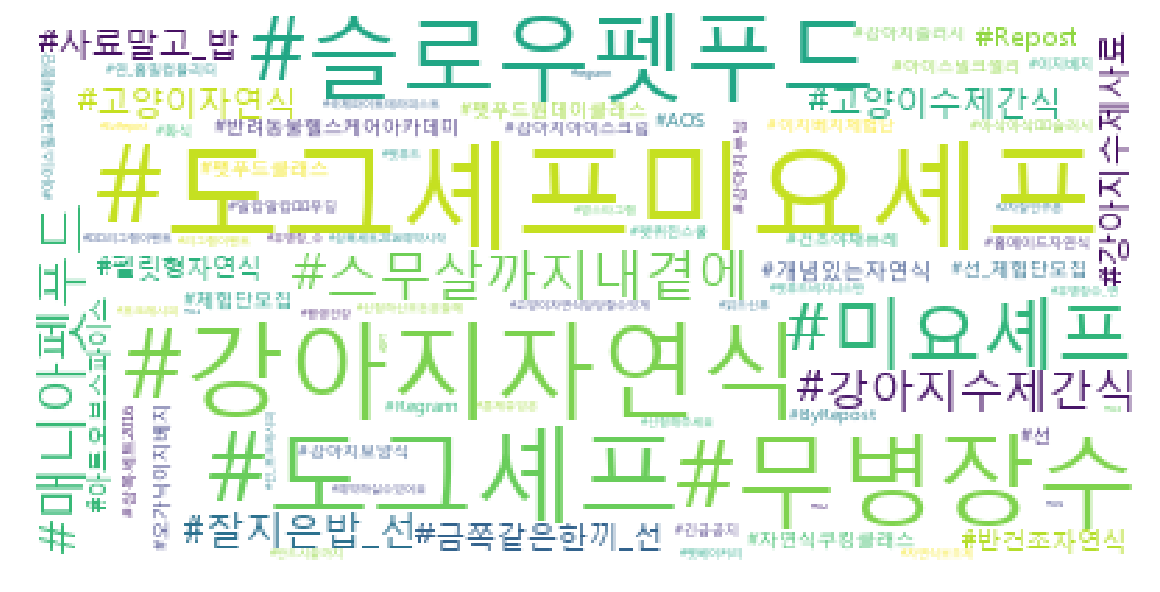

In [22]:
tag_result()